# Introduction

The goal of this project is to create useful streamlit application for Premier League forwards. 

There is a full code I made during this project. From webscraping through data processing to visulizations. I will try to guide step by step but have in mind it's just notebook and it might chaotic sometimes.

In [1]:
#packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import time
import json
import os
from cProfile import run
import streamlit as st
import themepy
from highlight_text import HighlightText, ax_text, fig_text
import matplotlib.font_manager
from IPython.core.display import HTML
import seaborn as sns
import shutil 
import matplotlib as mpl
from mplsoccer.pitch import VerticalPitch
from datetime import datetime
from PIL import Image

# Part 1 - Webscraping

To collect data I will use two main sources : fbref.com and understat.com. The first of these platfrom provides data on variety of football stats and some player info, while the second allows you to gather data on some match events like shot locations.

Same parts of the code might take a little longer as we are dealing with larger amount of data. Also be reasonable and try not to send to many requests to avoid overloading the servers (in some places I set up sleeper for a few seconds)

In [ ]:
#FRBREF DATA

# Players Info

url="https://fbref.com/en/comps/9/2021-2022/stats/2021-2022-Premier-League-Stats"
res = requests.get(url)
comm = re.compile("<!--|-->")
soup = BeautifulSoup(comm.sub("",res.text),'lxml')
all_tables = soup.findAll("tbody")
table=all_tables[2]
table=str(table)
table=table.split("href")

PlayersList=[]
LinksList=[]
NationalityList=[]
ClubsList=[]
AgeList=[]
PositionList=[]

for i in range(1,len(table),4):
    PlayersList.append(str(table[i]).split('</a></td><td class="',1)[0].split('">',1)[1])
    LinksList.append(str(table[i]).split('">',1)[0].split('="',1)[1])

for i in range(2,len(table),4):
    NationalityList.append(str(table[i]).split('-Football"><span style=',1)[0].split('/')[4])
    PositionList.append(str(table[i]).split('</td><td class="left" data-stat=',1)[0].split('"position">')[1])

for i in range(3,len(table),4):
    ClubsList.append(str(table[i]).split('</a></td><td class="center" data-stat="age">',1)[0].split('Stats">',1)[1])
    AgeList.append(str(table[i]).split('</td><td class="center" data-stat="birth')[0].split('data-stat="age">',1)[1])

df = pd.DataFrame(list(zip(PlayersList, LinksList,NationalityList,ClubsList,AgeList,PositionList)),
columns =['Name', 'Link','Nation','Club','Age','Position'])

df=df[df['Position']=="FW"]
df.reset_index(drop=True,inplace=True)
df.to_csv("info_epl_strikers.csv")
df.head()

,Name,Link,Nation,Club,Age,Position
0,Che Adams,/en/players/f2bf1b0f/Che-Adams,Scotland,Southampton,25,FW
1,Michail Antonio,/en/players/ac05f970/Michail-Antonio,Jamaica,West Ham,31,FW
2,Adam Armstrong,/en/players/68c720b5/Adam-Armstrong,England,Southampton,24,FW
3,Pierre-Emerick Aubameyang,/en/players/d5dd5f1f/Pierre-Emerick-Aubameyang,Gabon,Arsenal,32,FW
4,Jordan Ayew,/en/players/da052c14/Jordan-Ayew,Ghana,Crystal Palace,29,FW


In [ ]:
#Players Stats

links= df['Link'].tolist()
players=df['Name'].tolist()
urls=[]
for link in links:
    urls.append(str('https://fbref.com/en/players/'+link.split('/')[3]+'/matchlogs/2021-2022/summary/'+link.split('/')[4]+'-Match-Logs'))

fb_data=[]
for i in range(0,len(urls)):
    data = pd.read_html(urls[i])
    data[0]["name"]=players[i]
    fb_data.append(data[0])
    time.sleep(3)
fb_data = pd.concat(fb_data)
fb_data.to_csv("fbref_epl_strikers.csv")

In [ ]:
#Images

image_df=df
image_df["Image"]=""
imageLinks=[]
for i in range(0,len(urls)):
    res = requests.get(urls[i])
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    all_images = soup.findAll("img")
    if len(all_images)==4:
        imageLinks.append(str(all_images[1]).split('" style=""')[0].split('class="" src="',1)[1])
    else:
        imageLinks.append(str("No image"))
    time.sleep(4)

image_df["Image"]=pd.Series(imageLinks)
image_df.to_csv("images_epl_strikers.csv")

,Name,Link,Nation,Club,Age,Position,Image
0,Che Adams,/en/players/f2bf1b0f/Che-Adams,Scotland,Southampton,25,FW,
1,Michail Antonio,/en/players/ac05f970/Michail-Antonio,Jamaica,West Ham,31,FW,
2,Adam Armstrong,/en/players/68c720b5/Adam-Armstrong,England,Southampton,24,FW,
3,Pierre-Emerick Aubameyang,/en/players/d5dd5f1f/Pierre-Emerick-Aubameyang,Gabon,Arsenal,32,FW,
4,Jordan Ayew,/en/players/da052c14/Jordan-Ayew,Ghana,Crystal Palace,29,FW,


In [ ]:
#UNDERSTAT DATA

url = "https://understat.com/league/EPL/2021"
response = requests.get(url)
soup = BeautifulSoup(response.content, "lxml")
soup_scripts = soup.find_all("script")

script = soup_scripts[3].string
start_index = script.index("('")+2
end_index = script.index("')")
json_string = script[start_index:end_index]
json_string = json_string.encode("utf8").decode("unicode_escape")
players_dict = json.loads(json_string)

df2=pd.DataFrame(players_dict)
ids= df2['id'].tolist()

ud_data=[]
for id in ids:
    url="https://understat.com/player/"+id
    res=requests.get(url)
    soup=BeautifulSoup(res.content,"lxml")
    scripts=soup.find_all("script")
    strings3=scripts[3].string 
    ind_start3=strings3.index("('")+2
    ind_end3=strings3.index("')")
    json_data3=strings3[ind_start3:ind_end3]
    json_data3=json_data3.encode("utf8").decode("unicode_escape")
    data3=json.loads(json_data3)
    data4=pd.DataFrame(data3)
    ud_data.append(data4)
    time.sleep(2)
ud_data = pd.concat(ud_data)
ud_data.to_csv("understat_epl_strikers.csv")

# Part 2 - Data Preparing

As we scraped data from different sources it needs some work, but the code should be pretty straightforward.

In [3]:
#Load data and some operations

df=pd.read_csv("info_epl_strikers.csv")
image_df=pd.read_csv("images_epl_strikers.csv")
ud_data=pd.read_csv("understat_epl_strikers.csv")
fb_data=pd.read_csv("fbref_epl_strikers.csv")

fb_data.columns = fb_data.iloc[0] 
fb_data = fb_data[1:]
fb_data.columns = [*fb_data.columns[:-1], 'name']

fb_uni=fb_data["name"].unique()
ud_uni=ud_data["player"].unique()
commons=np.intersect1d(fb_uni,ud_uni)
ud_data=ud_data[ud_data["player"].isin(commons)]
fb_data=fb_data[fb_data["name"].isin(commons)]
image_df=image_df[image_df["Name"].isin(commons)]
df=df[df["Name"].isin(commons)]
ud_data=ud_data[ud_data["season"]==2021]
image_df.reset_index(drop=True,inplace=True)
df.reset_index(drop=True,inplace=True)
ud_data.reset_index(drop=True,inplace=True)
fb_data.reset_index(drop=True,inplace=True)

fb_data=fb_data[fb_data["Comp"]=="Premier League"]
new = fb_data["Round"].str.split(" ", n = 1, expand = True)
fb_data["Gameweek"]= new[1]
fb_data["Gameweek"]=fb_data["Gameweek"].astype(int)
fb_data.drop(columns =["Round"], inplace = True)
fb_data["Date"] = pd.to_datetime(fb_data["Date"])

radar_df=fb_data

fb_data=fb_data[fb_data["name"]=="Che Adams"]
fb_data = fb_data.sort_values(by="Gameweek")
fb_data=fb_data[(fb_data["Gameweek"]>=1)&(fb_data["Gameweek"]<=38)]

mga_data=fb_data[['Gls','Ast']]
mga_data=mga_data.replace("On matchday squad, but did not play","0")
mga_data.reset_index(drop=True,inplace=True)
mga_data['Matches']=1
mga_data=mga_data.astype(float)
mga_data=mga_data.astype(int)
mga_data=mga_data.sum()


In [4]:
#Data for table heatmap

form_df=fb_data.iloc[-5:]

form_df=form_df[['Date','Opponent','Min','Gls','Ast','Sh','Cmp']]
form_df=form_df.replace("On matchday squad, but did not play","0")
form_df['Date'] = form_df['Date'].apply(lambda x: x.strftime("%m/%d/%Y"))
form_df["Match"]=form_df["Date"]+" vs "+form_df["Opponent"]
form_df=form_df.set_index("Match")
form_df=form_df[['Min','Gls','Ast','Sh','Cmp']]
form_df.head()

,Min,Gls,Ast,Sh,Cmp
Match,,,,,
04/24/2022 vs Brighton,90,0,0,0,22
04/30/2022 vs Crystal Palace,64,0,0,2,13
05/07/2022 vs Brentford,0,0,0,0,0
05/17/2022 vs Liverpool,9,0,0,0,2
05/22/2022 vs Leicester City,28,0,0,1,7


In [5]:
# Data for timeline plot

goals_df=fb_data[["name","Gls","xG","Gameweek"]]
goals_df=goals_df[goals_df["name"]=="Che Adams"]
goals_df=goals_df.dropna()
goals_df = goals_df[goals_df["xG"].str.contains("On matchday squad, but did not play") == False]
goals_df["xG"]=pd.to_numeric(goals_df["xG"])
goals_df["Gls"]=pd.to_numeric(goals_df["Gls"])
goals_df.reset_index(drop=True,inplace=True)
goals_df["diff"]=goals_df["Gls"]-goals_df["xG"]
goals_df["diff_MA5"]=goals_df["diff"].rolling(5).mean()
goals_df["sum"]=goals_df["diff_MA5"].cumsum()
goals_df.head()

,name,Gls,xG,Gameweek,diff,diff_MA5,sum
0,Che Adams,0,0.0,1,0.0,NaN,NaN
1,Che Adams,0,0.3,2,-0.3,NaN,NaN
2,Che Adams,0,0.1,3,-0.1,NaN,NaN
3,Che Adams,0,0.1,5,-0.1,NaN,NaN
4,Che Adams,0,0.2,6,-0.2,-0.14,-0.14


In [6]:
# Data for radar plot

radar_df=radar_df[(radar_df["Gameweek"]>=10)&(radar_df["Gameweek"]<=38)]

radar_df=radar_df[["Min","xG","xA","Sh","Press","Tkl","Int","SCA", "Carries","name"]]
radar_df=radar_df.dropna()
radar_df = radar_df[radar_df["xG"].str.contains("On matchday squad, but did not play") == False]
radar_df[["Min","xG","xA","Sh","Press","Tkl","Int","SCA","Carries"]]=radar_df[["Min","xG","xA","Sh","Press","Tkl","Int","SCA","Carries"]].apply(lambda x:pd.to_numeric(x))
radar_df.reset_index(drop=True,inplace=True)

radar_df=radar_df.groupby("name").sum()
radar_df[["xG","xA","Sh","Press","Tkl","Int","SCA","Carries"]]=radar_df[["xG","xA","Sh","Press","Tkl","Int","SCA","Carries"]].apply(lambda x:x/(radar_df["Min"]/90))
radar_df.reset_index(inplace=True)
radar_df.head()

,name,Min,xG,xA,Sh,Press,Tkl,Int,SCA,Carries
0,Aaron Connolly,96.0,0.000000,0.375000,0.937500,8.437500,0.000000,0.000000,0.937500,12.187500
1,Adam Armstrong,798.0,0.270677,0.124060,2.932331,13.646617,0.676692,0.902256,1.917293,22.105263
2,Adama Traoré,445.0,0.161798,0.121348,1.415730,12.943820,0.606742,0.000000,2.224719,36.404494
3,Andriy Yarmolenko,276.0,0.228261,0.032609,2.934783,15.652174,0.652174,0.326087,1.630435,29.021739
4,Anthony Elanga,1214.0,0.214992,0.133443,1.556837,21.425041,1.853377,1.408567,1.334432,32.545305


In [7]:
labels=list(radar_df.columns)
labels.remove("Min")
labels

['name', 'xG', 'xA', 'Sh', 'Press', 'Tkl', 'Int', 'SCA', 'Carries']

# Part 3 - Visualizations

There are all plots I used later on in streamlit app. Lots of tests and modifications, so the code might be suboptimal and a bit chaotic

In [8]:
#Creating theme for plots
theme = themepy.Theme()
theme.set_theme()

(theme
 .set_font("Open Sans", color="black") 
 .set_pips(False) 
 .set_spines("off", which=[], color="black") 
 .set_background("white") 
 .set_ticklabel_size(8) 
 .set_plot_colors("#DC5349","#26D8FF","#D3CFBD") 
)
theme.add_theme("pavel_light")
theme.set_theme("pavel_light")

Theme pavel_light successfully overwritten


pavel_light is the active theme

In [9]:
# Viz I - Heatmap table

form_df=form_df.astype(int)
cm = sns.light_palette("green", as_cmap=True)
form_df.style.background_gradient(cmap=cm) 


,Min,Gls,Ast,Sh,Cmp
Match,,,,,
04/24/2022 vs Brighton,90,0,0,0,22
04/30/2022 vs Crystal Palace,64,0,0,2,13
05/07/2022 vs Brentford,0,0,0,0,0
05/17/2022 vs Liverpool,9,0,0,0,2
05/22/2022 vs Leicester City,28,0,0,1,7


In [10]:
# Viz II - comparison line plot

fig, ax = plt.subplots(figsize=(16,9))

ax.axis('off')
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.8)
grid = plt.GridSpec(1, 1,wspace=0, hspace=0)
ax=fig.add_subplot(grid[:, :])

x=goals_df.index.values
y=goals_df["sum"]
ax.plot(x, y,c="#FF69B4",alpha=0.6,linewidth=3,zorder=4)
ax.axhline(y=0, color='white',zorder=1,ls="--",lw=2,alpha=0.6)

ax.set_xlabel("Games", fontsize=12)
ax.set_ylabel("Goals-xG", fontsize=12)
ax.tick_params(labelsize=8)

transform = ax.transAxes
fig.text(0.5, 0.95, "Premier League, season 2021/2022", 
                ha = 'center',color = "w", alpha=0.4,
                font={'size':14,'family':"Open Sans","weight":"medium"})
fig_text(x = 0.5, y = 0.87,s="<CHE ADAMS ><TIMELINE PLOT >",ha='center', va='center',
highlight_textprops=[{"color": "#FF69B4",'size':30,'family':"Open Sans","weight":"bold","alpha":0.8},
                {"color": "w",'size':30,'family':"Open Sans","weight":"bold","alpha":0.8}])
fig.text(0.5, 0.82, "Plot of cumulative rolling averages Goals-xG", 
                ha = 'center',color = "w", alpha=0.6,
                font={'size':20,'family':"Open Sans","weight":"medium"})
fig.text(0.5, 0.05, "Rolling averages of last 5 games was applied", 
                ha = 'center',color = "w", alpha=0.4,
                font={'size':12,"style":"italic"})


Text(0.5, 0.05, 'Rolling averages of last 5 games was applied')

In [14]:
# Viz III - radar plot

def make_radar(df,labels, player1):
    
    df_resized=df[labels]


    #PERCENTILES
    labels_per90=list(df_resized.columns)
    labels_per90.remove("name")
    labels_per90=list(labels_per90)
    labels_per90=np.array(labels_per90)
    df= df_resized.loc[:, df_resized.columns != 'name'].rank(pct=True).round(decimals=2)
    df=pd.concat([df_resized["name"],df],axis=1)

    #DEFINING DF
    p1=df[df["name"]==player1]
    p1=p1.reset_index()


    #MAKING RADAR
    N = len(labels_per90)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    px = 1/plt.rcParams['figure.dpi']
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(350*px,350*px))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)

    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
 

    plt.xticks(angles[:-1], labels_per90, color='black', size=10, fontname='Open Sans', fontweight='medium')
    
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction('clockwise')
 
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8,1.0], ['20th','40th','60th','80th','100th'], color="black", 
               size=8, fontname='Open Sans', fontweight='light' )
    plt.ylim(0,1)
 
    # player
    values=p1.loc[0,labels_per90].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label="Player 1", color='#50C878')
    ax.fill(angles, values, '#50C878', alpha=0.25)
    
    
    ax.grid(color='#ECECEE')
    ax.spines['polar'].set_color("w")
    ax.set_facecolor("#F5F5DC")
    plt.show()

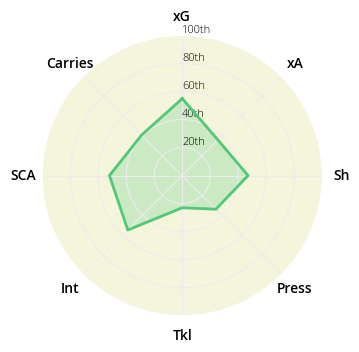

In [15]:
make_radar(df=radar_df,labels=labels,player1="Che Adams")

In [16]:
# Viz IV - shot map

ud_data['date']=ud_data['date'].apply(lambda x: x.split(' ',1)[0])
ud_data['Date']=ud_data['date']
ud_data['name']=ud_data['player']
ud_data['Date']=pd.to_datetime(ud_data['date'])
tmp=fb_data[['name','Gameweek','Date']]
temp=pd.merge(tmp,ud_data, on=['Date','name'], how='inner')

hist_df=temp[['shotType']]

shot_df=temp[['minute','result','player','date','X','Y','xG']]
shot_df[['X']]=shot_df[['X']].apply(lambda x: (x/100)*120*100)
shot_df[['Y']]=shot_df[['Y']].apply(lambda x: (x/100)*80*100)
shot_df=shot_df[shot_df['player']=='Che Adams']
shot_df.head()

C:\Users\Paweł Zajdel\AppData\Local\Temp\ipykernel_72\3944737081.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_df[['X']]=shot_df[['X']].apply(lambda x: (x/100)*120*100)
C:\Users\Paweł Zajdel\AppData\Local\Temp\ipykernel_72\3944737081.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_df[['Y']]=shot_df[['Y']].apply(lambda x: (x/100)*80*100)


,minute,result,player,date,X,Y,xG
0,29,MissedShots,Che Adams,2021-08-22,98.160004,37.520001,0.066345
1,74,MissedShots,Che Adams,2021-08-22,114.239996,33.200000,0.051274
2,12,SavedShot,Che Adams,2021-08-28,89.760004,36.879999,0.020017
3,67,BlockedShot,Che Adams,2021-08-28,108.239996,51.359998,0.059642
4,53,MissedShots,Che Adams,2021-09-18,101.280002,29.200000,0.056274


In [19]:
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#F5F5DC', line_color='#02075d',half=True)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#001a4d')

plt.gca().invert_xaxis()

sc1=pitch.scatter(shot_df['X'],shot_df['Y'],ax=ax,color='#50C878',s=shot_df['xG']*700)

# Part 4 - Streamlit

Full code for streamlit app is in anoher file called app_strikers.py

# Conclusions

To sum up, i found this project really fun and usefull. I need to say I didn't think simple visulization project will require from me so many tasks and challenges that I encoutered along the way.

Overall I'm pretty happy with the look of the app. Surely there a huge room for imporvements. I would like to fully use the possibilities offered by streamlit like saving plots, adding more interactive plots etc. Another thing is real-time data (or like daily updated at least). These are just some of the ideas I have and I will try to implement them in the future.